In [24]:
import pandas as pd
import numpy as np

# Load the data
file_path = 'mixed_playlist.csv'  # Adjust the path if necessary
mixed_playlist = pd.read_csv(file_path)

# Inspect the dataset
mixed_playlist.head()


,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,...,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
0,"Variations on a Polish Theme, Op. 10: No. 5 An...","Szymanowski: Piano Works, Vol. 2",Karol Szymanowski,06/12/1996,76933,53,0.9960,0.329,0.00695,0.866000,...,0.0448,70.295,0.238,4,11,0,spotify:track:3bcdLMrAxrfn5dxInjIdI2,1996,unknown,unknown
1,Je vous trouve un charme fou - En duo avec Gaë...,Il suffit d'y croire (Version deluxe),Hoshi,2018-11-30,172626,62,0.6220,0.615,0.59900,0.000008,...,0.2530,86.976,0.626,4,1,1,spotify:track:0C2yaSWVgCUiiqPyYxSOkd,2018,2024,delta
2,Me Gusta,On ira où ?,DTF,2019-10-11,175269,72,0.4130,0.834,0.73400,0.000040,...,0.3410,89.989,0.356,4,6,0,spotify:track:6P3FBaZfUjeWYExU2ShaPZ,2019,2022,gamma
3,L’amour en Solitaire,Petite Amie (Deluxe),Juliette Armanet,2018-02-02,175266,0,0.4040,0.797,0.50600,0.000153,...,0.0327,128.027,0.539,4,5,0,spotify:track:2tn51grfchxArwPXeXkoX5,2018,2020,gamma
4,Goodnight Moon,Volta,Boogie Belgique,2016-09-23,264735,53,0.0616,0.788,0.67500,0.711000,...,0.0318,107.993,0.525,4,7,0,spotify:track:2rvo9Ddv18aRV0OJldhWTf,2016,2022,alpha


In [25]:
mixed_playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3591 non-null   object 
 1   album             3591 non-null   object 
 2   artist            3600 non-null   object 
 3   release_date      3600 non-null   object 
 4   length            3600 non-null   int64  
 5   popularity        3600 non-null   int64  
 6   acousticness      3600 non-null   float64
 7   danceability      3600 non-null   float64
 8   energy            3600 non-null   float64
 9   instrumentalness  3600 non-null   float64
 10  liveness          3600 non-null   float64
 11  loudness          3600 non-null   float64
 12  speechiness       3600 non-null   float64
 13  tempo             3600 non-null   float64
 14  valence           3600 non-null   float64
 15  time_signature    3600 non-null   int64  
 16  key               3600 non-null   int64  


In [27]:
# Filter out rows where user or top_year is not missing
labeled_data = mixed_playlist.dropna(subset=['user', 'top_year'])

# Group by user and top_year to reconstruct playlists
reconstructed_playlists = labeled_data.groupby(['user', 'top_year'])


print(f"Labeled data: {len(labeled_data)} songs")
print(f"Unlabeled data: {len(reconstructed_playlists)} songs")


Labeled data: 3600 songs
Unlabeled data: 36 songs


In [28]:
# Filter songs without user or top_year
unlabeled_data = mixed_playlist[mixed_playlist['user'].isna() | mixed_playlist['top_year'].isna()]


In [32]:
# Filter labeled and unlabeled data
labeled_data = mixed_playlist.dropna(subset=['user', 'top_year'])
unlabeled_data = mixed_playlist[mixed_playlist['user'].isna() | mixed_playlist['top_year'].isna()]

# Handle missing feature values
features = ['release_year', 'popularity', 'danceability', 'energy', 'tempo', 'valence']
labeled_data = labeled_data.dropna(subset=features)
unlabeled_data = unlabeled_data.dropna(subset=features)

# Check if there's any data to process
if unlabeled_data.empty:
    print("All songs are labeled. No inference required.")
else:
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import StandardScaler

    # Scale the features
    scaler = StandardScaler()
    labeled_features = scaler.fit_transform(labeled_data[features])
    unlabeled_features = scaler.transform(unlabeled_data[features])

    # Fit nearest neighbors model
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
    nn.fit(labeled_features)

    # Predict user and top_year for unlabeled data
    distances, indices = nn.kneighbors(unlabeled_features)
    unlabeled_data['user'] = labeled_data.iloc[indices.flatten()]['user'].values
    unlabeled_data['top_year'] = labeled_data.iloc[indices.flatten()]['top_year'].values

    print("Inference completed for unlabeled songs.")


All songs are labeled. No inference required.


In [33]:
# Combine labeled and inferred data
final_playlists = pd.concat([labeled_data, unlabeled_data], ignore_index=True)

# Save the reconstructed playlists to a CSV file
final_playlists.to_csv('reconstructed_playlists.csv', index=False)
print("Reconstructed playlists saved to 'reconstructed_playlists.csv'.")


Reconstructed playlists saved to 'reconstructed_playlists.csv'.


In [34]:
# Recommend the next song based on similarity to the current song
current_song = final_playlists.iloc[0]  # Example: Use the first song as a reference

# Calculate similarity
from sklearn.metrics.pairwise import cosine_similarity

# Scale features
all_features = scaler.transform(mixed_playlist[features])
current_features = scaler.transform([current_song[features]])

# Compute similarity scores
similarity_scores = cosine_similarity(current_features, all_features).flatten()

# Get top recommendations
top_indices = np.argsort(similarity_scores)[-10:][::-1]  # Top 10 recommendations
recommended_songs = mixed_playlist.iloc[top_indices]
print(recommended_songs)


                                                   name  \
0     Variations on a Polish Theme, Op. 10: No. 5 An...   
709   Variations on a Polish Theme, Op. 10: No. 5 An...   
99                                   The Labyrinth Song   
855   Trois Romances sans paroles, Op. 17: 3. Andant...   
19                                       Palace - Cover   
1539                         Nocturne No. 10 In E Minor   
2691                                  Dumbledore's Army   
3002                                  Dumbledore's Army   
357                                       Natural Light   
159   Wiegenlied, Op. 49, No. 4 (Arr. for Cello and ...   

                                                  album             artist  \
0                      Szymanowski: Piano Works, Vol. 2  Karol Szymanowski   
709                    Szymanowski: Piano Works, Vol. 2  Karol Szymanowski   
99                                          Gold Shadow        Asaf Avidan   
855                                  F

C:\Users\SURANJANA\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


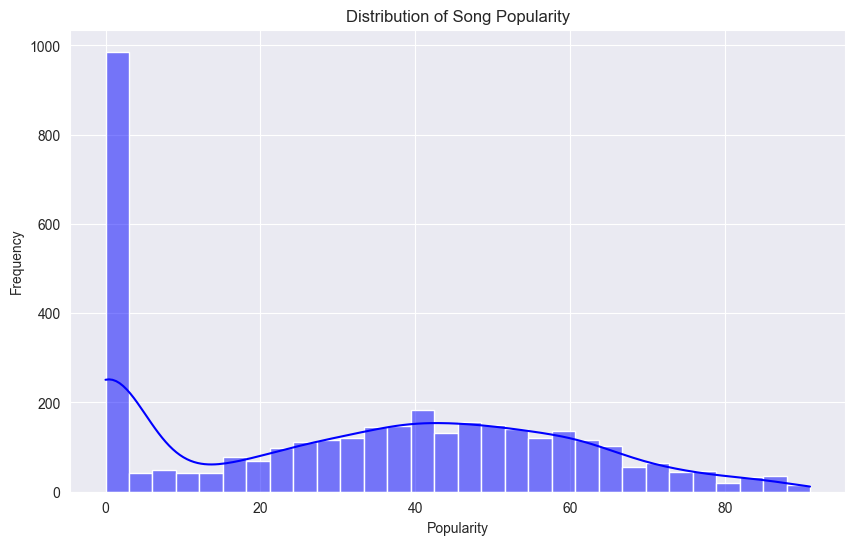

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of song popularity
plt.figure(figsize=(10, 6))
sns.histplot(mixed_playlist['popularity'], bins=30, kde=True, color='blue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()


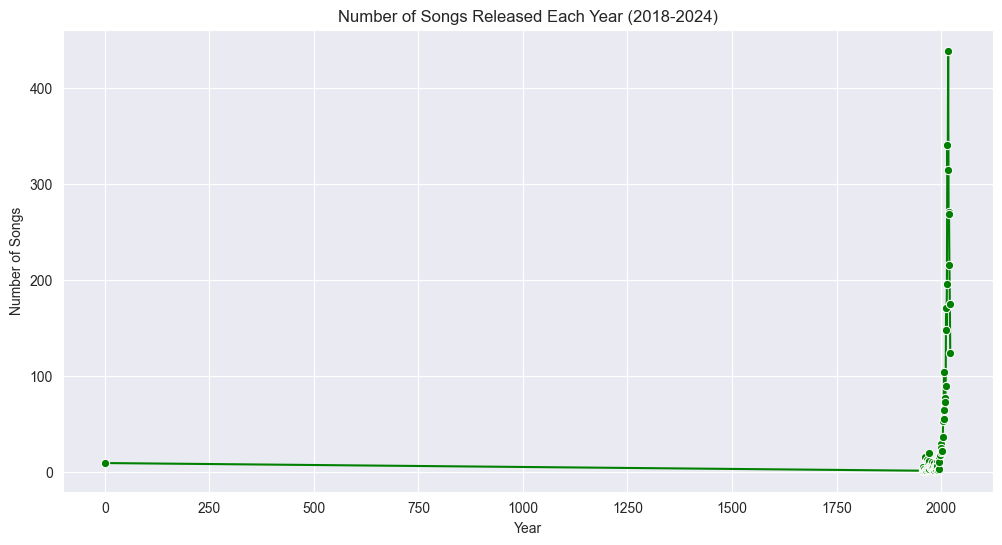

In [37]:
# Count the number of songs per year
songs_per_year = mixed_playlist['release_year'].value_counts().sort_index()

# Plot the trend of song releases over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=songs_per_year.index, y=songs_per_year.values, marker='o', color='green')
plt.title('Number of Songs Released Each Year (2018-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.show()


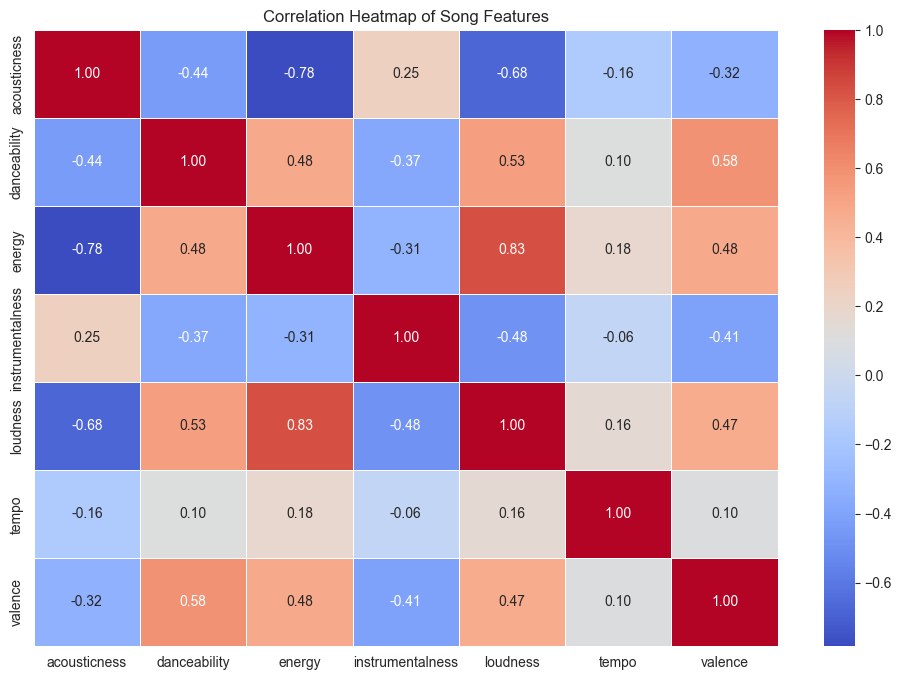

In [38]:
# Select numerical columns for correlation analysis
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'tempo', 'valence']
corr_matrix = mixed_playlist[features].corr()

# Plot the heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Song Features')
plt.show()


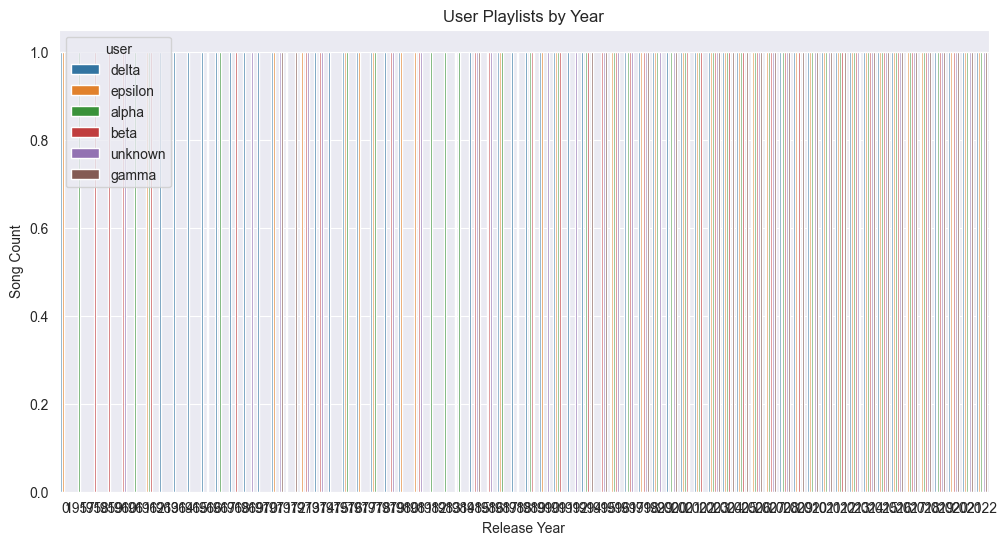

In [39]:
# Group the data by user and year to see the playlists for each user across years
user_playlist = mixed_playlist.groupby(['user', 'release_year']).size().reset_index(name='song_count')

# Visualize the playlists for each user
plt.figure(figsize=(12, 6))
sns.countplot(x='release_year', hue='user', data=user_playlist)
plt.title('User Playlists by Year')
plt.xlabel('Release Year')
plt.ylabel('Song Count')
plt.show()


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Select relevant features for the recommendation model
features = ['danceability', 'energy', 'acousticness', 'loudness', 'tempo']

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df[features])

# Calculate the cosine similarity matrix
similarity_matrix = cosine_similarity(normalized_features)

# Example: Recommend a song based on the most similar song in the dataset
song_index = 10  # Index of the song you want to recommend a similar one to
similar_songs = similarity_matrix[song_index]

# Get the top 5 most similar songs
similar_songs_indices = similar_songs.argsort()[-6:-1][::-1]  # excluding the song itself

recommended_songs = df.iloc[similar_songs_indices]
print(recommended_songs[['name', 'artist', 'release_year']])


                                                   name             artist  \
278                      Good Morning Mumbai (To Zakir)     Dhafer Youssef   
3513                                              Pause   The Art Of Noise   
3260                                      Autumn Leaves        Eva Cassidy   
551   Gli uccelli (The Birds), P. 154: V. Il cucu: A...  Ottorino Respighi   
1942                                   Etude in E Minor    Benedict Larsen   

      release_year  
278           2018  
3513          1999  
3260          2018  
551           2014  
1942          2022  
